### Predicting the Survival of Newborn Goats based on Follow-up Variables

### Table of Contents
1. Problem statements      
1.1. Performance Measures  
2. Aims of the Project   
3. Importing necessary Libraries and Data    
4. Data summary & EDA   
4.1. Summary Statistics    
4.2. Data Visualization    
5. Data Pre-Processing   
5.1. Data Cleaning  
5.2. Train-test Split     
5.3. Transformation Pipelines  
6. Modeling    
6.1. Training on train split   
6.2. Cross-validation  
7. Fine-tuning  
7.1. Hypeparametrization       
7.2. Evaluate on test set   
8. Deployment 

1. Problem Statement    
* The Problem is to predict the survival of Goat kids in selected goat and sheep farms. The datasets consist of several predictor (independent) variables and one target (dependent) variable, Outcome that are documented during my follow-up to the selected goat farms. Independent variables include the Time of 1st coll, Method of co. feeding,Amount of liquid diet, Parity of the dam, Weaning age, Cleaness of the barn, Housing, Education, Herd size, Age of the farm, Source of income, Owner ship, Sex of cc and Experience.   
* The evaluation metrics includes Precision(P), Recall(R), F1 Score and AUC

2. Aims of the Project  
* To build a machine learning model that accurately predict whether or not the Newborn kids in the dataset
will survive or not?

3. Importing Necessary Libraries & Loading Data

In [1]:
# import libraries for Data Loading & Preprocessing
import numpy as np 
import pandas as pd
import sklearn
import os 
import joblib

# Libraries for Visualization
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='notebook', color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

#for warning 
from warnings import filterwarnings
filterwarnings("ignore")

# for model accuracy and convergence 
np.random.seed(42)

In [2]:
def read_data(DataPath = '.'):
    """"""
    if os.path.exists(DataPath):
        return pd.read_csv(DataPath)
    else:
        print("File not Exist")

In [3]:
DATAPATH = "/home/miki/Desktop/Deployment/survival-analysis/data/Survival.csv"
df = read_data(DATAPATH)

In [4]:
df

,Event,Time of 1st coll,Method of co. feeding,Amount of liquid diet,Parity of the dam,Weaning age,Cleaness of the barn,Housing,Education,Herd size,Age of the farm,Source of income,Owner ship,Sex of cc,Experience
0,1,2,1,4,2,0,2,2,3,2,9,1,1,2,1
1,0,1,2,4,2,5,2,2,2,4,20,1,1,2,1
2,0,1,1,7,2,3,2,1,2,3,25,1,1,1,1
3,0,1,1,6,2,3,2,1,2,3,25,1,1,1,1
4,1,2,1,3,1,2,1,1,4,2,4,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1,2,2,4,2,0,2,1,2,4,15,2,1,1,2
180,1,2,2,3,2,3,1,2,5,4,15,2,1,1,1
181,1,2,2,4,2,0,1,2,2,6,25,1,2,1,1
182,1,2,1,4,2,0,1,2,2,6,25,1,2,1,1


4. Data Summary & EDA   
4.1. Summary Statistics

In [5]:
# # df.describe().transpose()
# def summary(x = None):
#     return x.describe().transpose().to_csv('summary.csv', index = False)

In [6]:
# summary(df)

4. Data Summary & EDA   
4.2. Visualization

In [7]:

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
def compareplots(x, title = None):
    fig, axes = plt.subplots(nrows= 1, ncols = 2, figsize = (18, 12), dpi = 80)
    # sns.pairplot(x,hue='Event',palette='gnuplot', ax=axes[0][0])
    sns.boxplot(data = x, palette = "Set1", ax=axes[0]).set(title='Data with Outliers')
    sns.heatmap(x.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=axes[1])
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    plt.show()

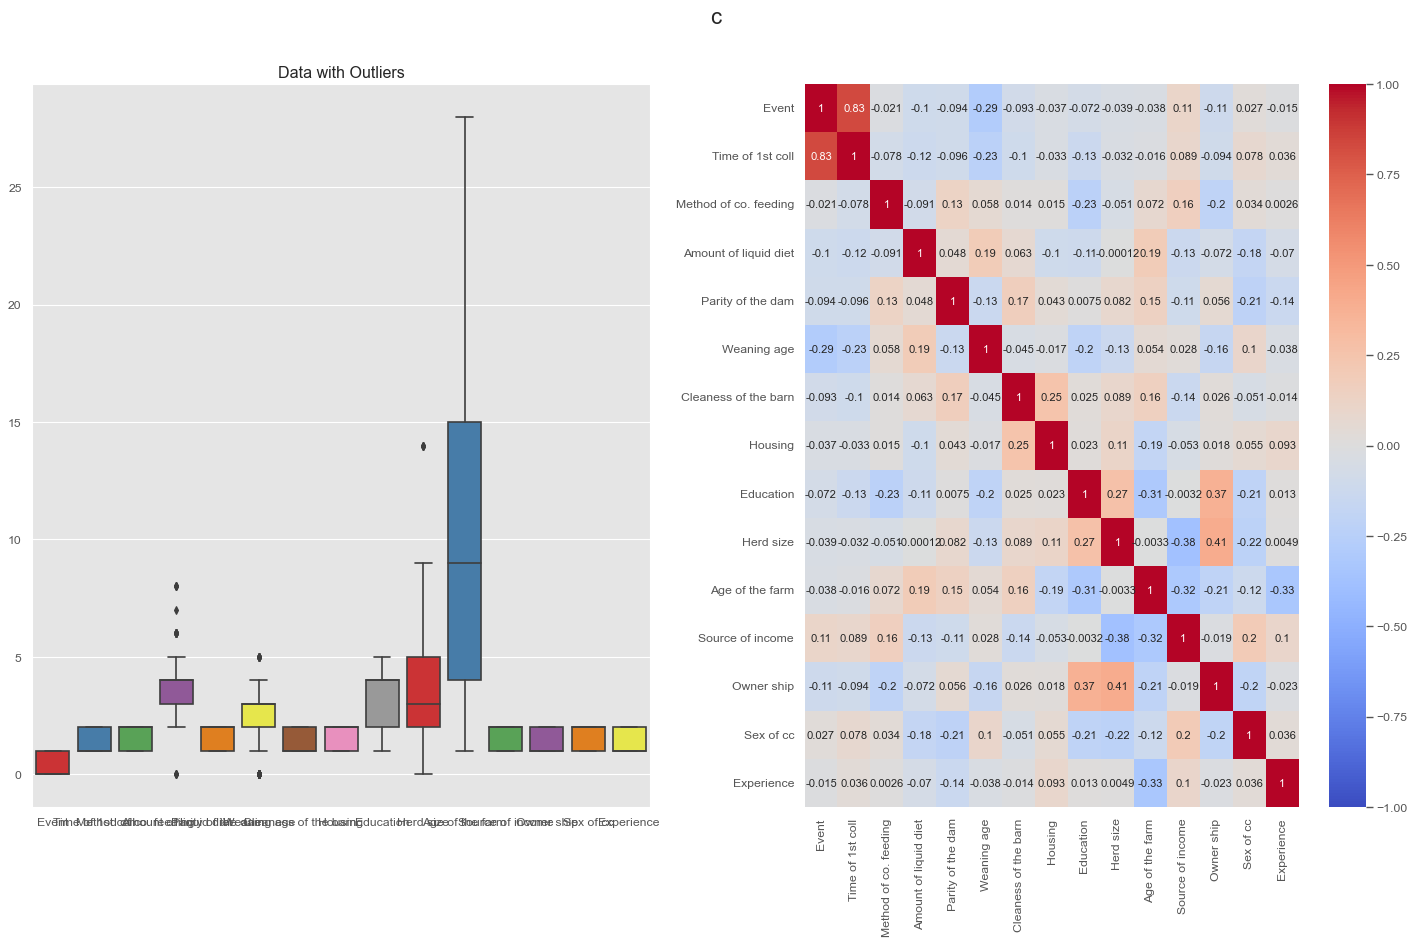

In [8]:
compareplots(df, 'c')

5. Data Pre-Processing  
    * 5.1. Data Cleaning

In [9]:
import scipy.stats as stats
#find Q1, Q3, and interquartile range for each column
def outlier_remove(x = None):
    """"""
    Q1 = x.quantile(q=.25)
    Q3 = x.quantile(q=.75)
    IQR = x.apply(stats.iqr)
    #only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
    cd = x[~((x < (Q1-1.5*IQR)) | (x > (Q3+1.5*IQR))).any(axis=1)]
    #find how many rows are left in the dataframe 
    return cd

In [10]:
clean_df = outlier_remove(df)

In [11]:
clean_df.shape

(123, 15)

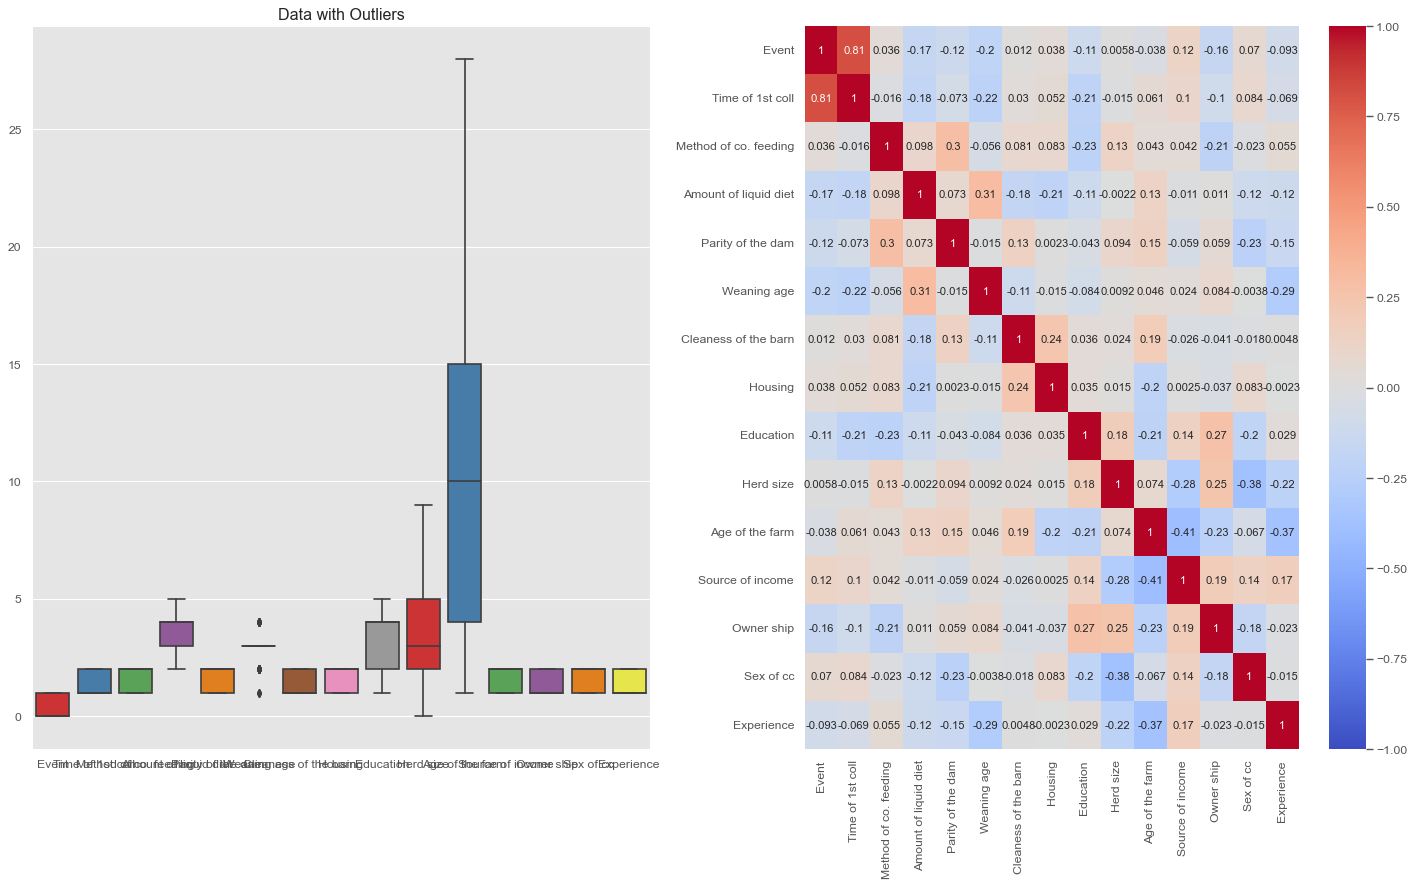

In [12]:
compareplots(clean_df)

5. Data Pre-Processing  
    * 5.1. Train-Test Split

In [15]:
def data_split(dfs = None, X= None, Y = None, train_size=0.8, test_size=0.2):
    """"""
    X_train, Y_train, X_val, Y_val = train_test_split(X, Y, test_size=test_size, 
                                        train_size=train_size, shuffle = False)
    return X_train, Y_train, X_val, Y_val

In [17]:
clean_df

,Event,Time of 1st coll,Method of co. feeding,Amount of liquid diet,Parity of the dam,Weaning age,Cleaness of the barn,Housing,Education,Herd size,Age of the farm,Source of income,Owner ship,Sex of cc,Experience
4,1,2,1,3,1,2,1,1,4,2,4,1,1,2,2
7,0,1,2,3,2,3,2,1,5,4,15,2,1,1,1
8,1,1,1,3,2,3,2,1,5,4,15,2,1,1,1
9,0,1,1,4,1,2,1,1,4,6,4,1,1,2,2
13,0,1,2,4,2,3,2,2,4,6,6,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0,1,2,2,2,2,2,2,5,5,10,1,2,1,1
172,0,1,2,3,2,4,2,2,3,2,20,2,1,2,1
174,0,1,1,3,1,3,2,2,4,3,5,2,2,2,1
180,1,2,2,3,2,3,1,2,5,4,15,2,1,1,1


In [18]:
X = clean_df.drop("Event",axis=1)
Y = clean_df["Event"]

5. Data Pre-Processing  
    * 5.3. Transformation Pipeline